# **Import Dataset and Libraries**

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from folium.plugins import HeatMap
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np
import folium
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Change File Location
df = pd.read_csv("C:/Users/aidan_000/Desktop/UNCC/ML Project/Datasets/df8.csv", low_memory=False)

coordinates = pd.DataFrame(df[['ZIP', 'LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC', 'CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP']].values, columns= ['ZIP', 'LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC', 'CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP'])
df.head()

,ZIP,LATITUDE_PUBLIC,LONGITUDE_PUBLIC,Year,Month,Day,DayOfWeek,CMPD_PATROL_DIVISION,LOCATION_TYPE_DESCRIPTION,PLACE_TYPE_DESCRIPTION,...,PctHH_Poverty,PctHome_Ownership,HighSchool,NonWhite,F65_,Poverty,Home_Ownership,Score,VulnerableBinary,Violent-Crime
0,28215,35.258195,-80.726229,2023,12,4,0,1,1,1,...,0.07,0.75,1,1,0,0,0,2,0,0
1,28213,35.283274,-80.762293,2023,12,4,0,2,1,2,...,0.16,0.76,1,1,0,1,0,3,0,0
2,28210,35.153683,-80.839845,2023,12,4,0,5,3,4,...,0.11,0.53,0,0,1,0,1,2,0,0
3,28227,35.221991,-80.814908,2023,12,4,0,6,1,4,...,0.04,0.77,0,0,0,0,0,0,0,0
4,28216,35.362708,-80.854438,2023,12,4,0,7,0,4,...,0.05,0.40,0,1,0,0,1,2,0,1


# **Pre-processing**

In [5]:
# validation_set = df[df['Year'] == 2023]
# training_set = df[df['Year'] != 2023]

# # Extract features and labels for the test set (2023)
# y_test = training_set['CRIME_TYPE_MAP'].values
# x_test = training_set.drop(columns=['CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP', 'Violent-Crime']).values

# # Extract features and labels for the training set (all years except 2023)
# y_train = validation_set['CRIME_TYPE_MAP'].values
# x_train = validation_set.drop(columns=['CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP', 'Violent-Crime']).values

# # Standardize the features if needed
# X_train = StandardScaler().fit_transform(x_train)
# X_test = StandardScaler().fit_transform(x_test)

# # Convert to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [14]:
Y = df[['CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP']]
y = df['CRIME_TYPE_MAP'].values

df = df.drop(columns=['CRIME_TYPE', 'HIGHEST_NIBRS_DESCRIPTION', 'HIGHEST_NIBRS_CODE', 'CRIME_TYPE_MAP', 'Violent-Crime'])

x = df.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

X_train = StandardScaler().fit_transform(x_train)
X_test = StandardScaler().fit_transform(x_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# **Model Declaration and Instantiation**

In [6]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model
class SpatiotemporalModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SpatiotemporalModel, self).__init__()
        self.conv1d = nn.Conv1d(input_size, 32, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(32, 50, batch_first=True)
        self.fc = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)  # Add a channel dimension for Conv1d
        x = F.relu(self.conv1d(x))
        x, _ = self.lstm(x.permute(0, 2, 1))  # LSTM expects input in (batch, seq_len, features) format
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        return x

# Instantiate the model for multi-class classification (8 classes)
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))  # Number of classes
model = SpatiotemporalModel(input_size, output_size).to(device)

# Use CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 300
for epoch in range(epochs):
    start_time = time.time()
    
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Move both inputs and labels to the device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    all_predictions = []
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted_labels = torch.max(outputs, 1)
            all_predictions.extend(predicted_labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
 
    val_accuracy = correct / total
    
    
    end_time = time.time()
    epoch_time = end_time - start_time

    # Print epoch information
    print(f"Epoch {epoch + 1}/{epochs}, Time: {epoch_time:.2f}s, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/300, Time: 9.88s, Validation Accuracy: 0.4737
Epoch 2/300, Time: 9.90s, Validation Accuracy: 0.5048
Epoch 3/300, Time: 9.96s, Validation Accuracy: 0.5150
Epoch 4/300, Time: 10.30s, Validation Accuracy: 0.5176
Epoch 5/300, Time: 9.48s, Validation Accuracy: 0.5187
Epoch 6/300, Time: 10.22s, Validation Accuracy: 0.5186
Epoch 7/300, Time: 10.10s, Validation Accuracy: 0.5180
Epoch 8/300, Time: 9.97s, Validation Accuracy: 0.5176
Epoch 9/300, Time: 10.15s, Validation Accuracy: 0.5181
Epoch 10/300, Time: 10.25s, Validation Accuracy: 0.5172
Epoch 11/300, Time: 10.03s, Validation Accuracy: 0.5173
Epoch 12/300, Time: 10.75s, Validation Accuracy: 0.5175
Epoch 13/300, Time: 10.53s, Validation Accuracy: 0.5174
Epoch 14/300, Time: 10.38s, Validation Accuracy: 0.5176
Epoch 15/300, Time: 10.07s, Validation Accuracy: 0.5182
Epoch 16/300, Time: 10.06s, Validation Accuracy: 0.5188
Epoch 17/300, Time: 10.00s, Validation Accuracy: 0.5193
Epoch 18/300, Time: 10.67s, Validation Accuracy: 0.5201
Epoch 

In [7]:
prediction_df = pd.DataFrame({
    'ZIP': x_test[:, 0],
    'LATITUDE_PUBLIC': x_test[:, 1],
    'LONGITUDE_PUBLIC': x_test[:, 2],
    'CRIME_TYPE_MAP': all_predictions
})

mapping_dict = {
    0 : 'Assault',
    1 : 'Thefts',
    2 : 'Vehicle Thefts', 
    3 : 'Property Offenses',
    4 : 'Sexual Offenses',
    5 : 'Money Offenses',
    6 : 'Drug Offenses',
    7 : 'Falsification'
}
prediction_df['PREDICTED_CRIME_TYPE'] = prediction_df['CRIME_TYPE_MAP'].map(mapping_dict)

# **Data Visualization**

Confusion Matrix Plot

              precision    recall  f1-score   support

           0       0.39      0.49      0.44     46236
           1       0.63      0.53      0.58     85245
           2       0.51      0.79      0.62     56759
           3       0.19      0.04      0.06     21847
           4       0.26      0.04      0.06      3412
           5       0.12      0.02      0.04      7576
           6       0.32      0.31      0.32     12611
           7       0.15      0.06      0.09      3825

    accuracy                           0.50    237511
   macro avg       0.32      0.29      0.27    237511
weighted avg       0.47      0.50      0.47    237511



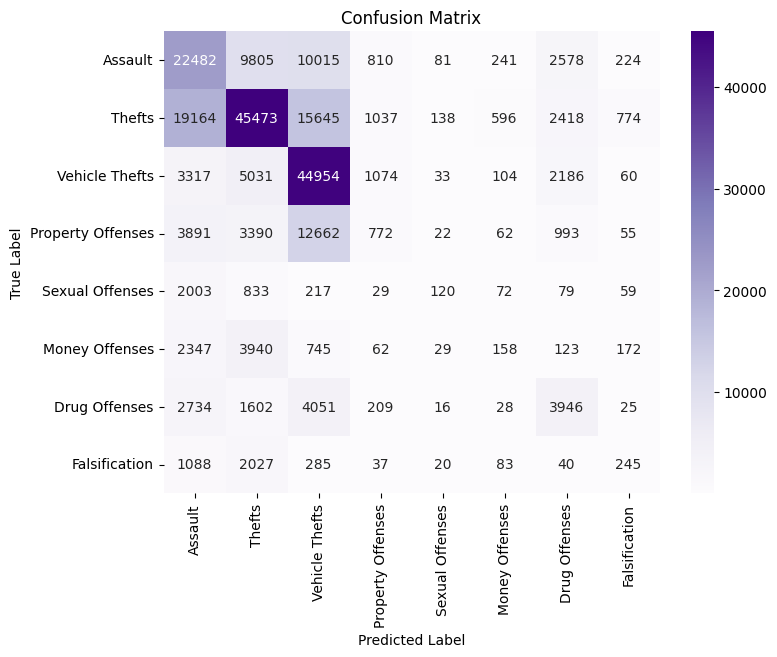

In [9]:
crime_types = ['Assault','Thefts','Vehicle Thefts','Property Offenses','Sexual Offenses','Money Offenses','Drug Offenses','Falsification']

y_test_np = y_test_tensor.cpu().numpy()
all_predictions_np = np.array(all_predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, all_predictions_np)

# Display classification report
report = classification_report(y_test_np, all_predictions_np, zero_division=1)
print(report)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=crime_types, yticklabels=crime_types)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Crime Prediction Map

In [11]:
minLatitude = coordinates.iloc[:, 1].min()
maxLatitude = coordinates.iloc[:, 1].max()

minLongitude = coordinates.iloc[:, 2].min()
maxLongitude = coordinates.iloc[:, 2].max()

centerLatitude = (minLatitude + maxLatitude) / 2
centerLongitude = (minLongitude + maxLongitude) / 2

CrimeType = 'Thefts'

PredictionMap = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=11)
PredictionPoints = prediction_df[prediction_df['PREDICTED_CRIME_TYPE'] == CrimeType][['LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC']]
HeatMap(PredictionPoints, min_opacity=0.2, radius=15, blur=25, gradient={0.4: 'blue', 0.65: 'lime', 1: 'yellow'}).add_to(PredictionMap)

PredictionMap.save('PredictionMap_MultiClassModel.html')

In [12]:
ActualMap = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=11)
ActualPoints = coordinates[coordinates['CRIME_TYPE'] == CrimeType][['LATITUDE_PUBLIC', 'LONGITUDE_PUBLIC']]
HeatMap(PredictionPoints, min_opacity=0.2, radius=15, blur=25, gradient={0.4: 'blue', 0.65: 'lime', 1: 'yellow'}).add_to(ActualMap)

ActualMap.save('ActualHeatmap_MultiClassModel.html')